In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import splitfolders

#(The following code need not be run again so it's commented out)
#splitfolders.ratio("data/", output="split-data/",
#                  seed = 42, ratio=(0.8, 0.15, 0.05))

In [ ]:
#Renaming filenames

import os
directory = "split-data/train/"

'''
##debugging file access (getting comfortable with 'os' and file handling in general)

for folder in os.listdir(directory): #'listdir' returns a list of all files/directories in the specified
    print(" ")
    count = 0
    if not os.path.isdir(folder): #'isdir' returns a boolean value: True if the current object is a directory, False otherwise
                              #this is to combat 'listdir' listing hidden files (such as .DS_Store on MacOS), causing errors
        continue
        
    folder_path = os.path.join(directory, folder) #'join' concatenates the first/second argument (creating a new path)
    print(folder_path)
    for filename in os.listdir(folder_path):
        old_path = os.path.join(folder_path, filename)
        print(old_path)
        count+=1
        if count == 3:
            break
'''


##Actually renaming the files:
#(similarly this code need not be run again)
'''
for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder)
    if not os.path.isdir(folder_path):
        continue
        
    count=1
    for filename in os.listdir(folder_path):
        old_path = os.path.join(folder_path, filename)
        if not os.path.isfile(old_path):
            continue
        extension = os.path.splitext(filename)[1] #retrieves extension by splitting on the filename
        new_name = f"{folder}_{count:04d}{extension}"
        new_path = os.path.join(folder_path, new_name)
        
        os.rename(old_path, new_path)
        #print(f"Renamed {old_path} to {new_path}")
        count+=1
'''

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Understanding what happens under the hood

- **ImageDataGenerator**: Does not actually store any data, rather it stores **rules** for data preprocessing, like:
  - preprocessing settings (rescaling, normalization, etc.)
  - augmentation rules (what transformations to apply - these are specified in the call)
  - configuration parameters (e.g. seed)
  **It's like the *blueprint* for generating the augmented images**

- **flow_from_directory**: An **iterator** is created to *scan the directory* passed into 'ImageDataGenerator'
  - loads the images into batches (using the specified sizes) *during training*
  - applies the preprocessing/agumentation rules specified by the 'ImageDataGenerator'
  - returns a 'DirectoryIterator' object,  which yields tuples of (X,y) when iterated (X is a batch of images, y is a *one-hot-encoded* vector of class labels)
  - using 'next()' the iterator advances to the next batch

In [5]:
#applying transformations (not finalized)

train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   shear_range = 0.1,
                                   rotation_range = 10,
                                   brightness_range = [0.8,1.2],
                                   horizontal_flip = True)

train_set = train_datagen.flow_from_directory(directory,
                                              target_size = (224,224),
                                              color_mode = "rgb",         # colored images
                                              class_mode = 'categorical', # multiple classes
                                              batch_size = 32,            # 32 images in each training batch
                                              shuffle = True,             # we don't want the model to memorize the order of the images
                                              seed = 42)                  # seed is added for reproducability

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

validation_set = validation_datagen.flow_from_directory("split-data/val",
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='categorical',
                                                        shuffle=False)    # no need to shuffle the validation/test sets

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_set = test_datagen.flow_from_directory('split-data/test',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='categorical',
                                            shuffle=False)

Found 10414 images belonging to 14 classes.
Found 1947 images belonging to 14 classes.
Found 663 images belonging to 14 classes.


In [6]:
train_set.class_indices

{'Corn_Common_Rust': 0,
 'Corn_Gray_Leaf_Spot': 1,
 'Corn_Healthy': 2,
 'Corn_Northern_Leaf_Blight': 3,
 'Potato_Early_Blight': 4,
 'Potato_Healthy': 5,
 'Potato_Late_Blight': 6,
 'Rice_Brown_Spot': 7,
 'Rice_Healthy': 8,
 'Rice_Leaf_Blast': 9,
 'Rice_Neck_Blast': 10,
 'Wheat_Brown_Rust': 11,
 'Wheat_Healthy': 12,
 'Wheat_Yellow_Rust': 13}

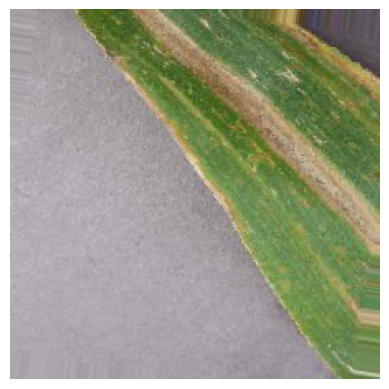

Label:  Corn_Northern_Leaf_Blight


In [7]:
images, labels = next(train_set)
# next() returns the 'next' batch of 32 images

plt.imshow(images[0])
plt.axis('off')
plt.show()

print("Label: ", list(train_set.class_indices.keys())[np.argmax(labels[0])]) #np.argmax returns the index of the largest value in the list
                                                                             #(which will be 1) which can be used to determine the class

Sanity check to ensure data augmentation works as expected and labels are correct

In [8]:
# checking for corrupt files
from PIL import Image
count = 0
for folder_name in os.listdir(directory):
    folder_path = os.path.join(directory, folder_name)
    if not os.path.isdir(folder_path):
        continue
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if not os.path.isdir(file_path):
            break
        try:
            im = Image.open(file_path)
            im.verify()
            im.close()
        except (IOError, OSError, Image.DecompressionBombError):
            print(f"Fail: {filename}")
            count+=1

print(count, "corrputed files")

0 corrputed files


No corrupt files

In [9]:
# exploring / handling class imbalances
for folder_name in os.listdir(directory):
    count = 0
    folder_path = os.path.join(directory, folder_name)
    if not os.path.isdir(folder_path):
        continue
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        count+=1
    print(folder_name, ": ", count)

Potato_Late_Blight :  800
Corn_Healthy :  929
Wheat_Healthy :  892
Corn_Common_Rust :  954
Rice_Neck_Blast :  800
Potato_Early_Blight :  800
Rice_Leaf_Blast :  781
Wheat_Yellow_Rust :  740
Potato_Healthy :  121
Rice_Healthy :  1191
Corn_Gray_Leaf_Spot :  411
Wheat_Brown_Rust :  721
Corn_Northern_Leaf_Blight :  788
Rice_Brown_Spot :  490


In [ ]:
#we can aim to have 700-1000 images in each class

'''
Classes to be oversampled:
- Potato Healthy: 121
- Corn Gray Leaf Spot: 410
- Rice Brown Spot: 490

'Rice Healthy' may be undersampled to 900-1000 observations
'''